
#Tarea 3
---
*03-06-2023*

*Martín Gallegos*

# Identificación

In [1]:
Nombre = "Bruno Farfán"
id = "2064230J"

# Preguntas Teóricas:

## Pregunta 1:

Que el problema sea de tipo Markoviano es importante, ya que nos permite resumir todo el entorno en el estado actual del modelo (ya que la probabilidad de ocurrencia de estados futuros solamente depende del estado actual), haciendo que el Actor pueda tomar una acción basandose exclusivamente en el estado actual, y con este obtener una imagen completa del mundo en el que se encuentra.
Si el problema no fuese Markoviano, entonces el modelo tendría que tener en consideración los estados pasados para tomar una acción y aunque el algoritmo considera estocasticidad y por lo tanto tiene resultados futuros inciertos, como se mencionó, esta incertidumbre depende exclusivamente del estado actual y no de los estados pasados.

## Pregunta 2:

La función `Q(s,a)` nos entrega la recompensa de ejecutar la acción `a` cuando estamos en el estado `s`. Es decir, nos está diciendo que tan bueno o malo es tomar una acción `a` cuando nos encontramos en el estado `s`.
Nos interesa estimarla, debido a que al decirnos que tan buena o mala es cierta acción en determinado estado, nos está dando una guía o mapa para proceder dentro del mundo del agente. Con una función `Q` precisa el agente podrá predecir mejor el impacto de sus decisiones y planificar sus acciones futuras, generando así una política cada vez mejor para interactuar con su mundo.

## Pregunta 3:

La implementación de dos redes neuronales para estimar la función `Q` es debido a que tener dos redes neuronales ayuda a evitar el sesgo de sobreestimación, lo que es común en modelos de RL basados en estimación de la función `Q`. Al entrenar se usan dos redes independientes y se actualizan los parámetros con el mínimo entre las estimaciones de ambas redes.
Además al tener dos redes el entrenamiento se logra hacer más estable ya que las redes pueden irse compensando mutuamente.

## Pregunta 4:

Que un algoritmo de aprendizaje RL sea _model-free_ significa que no necesita un modelo explícito de su entorno para aprender a tomar decisiones. Es decir el agente aprende mediante sus interacciones con el entorno y no necesita conocer la función de recompensa.
Que un algoritmo sea _off-policy_ quiere decir que puede aprender la política óptima utilizando experiencias que no fueron generadas por la política que está siendo actualmente aprendida. Es decir, puede aprender de un _buffer_ que fue generado por otra política.

## Pregunta 5:

El algoritmo SAC aborda el _trade-off_ entre exploración y explotación mediante el uso de **entropía**. La entropía mide el grado de incertidumbre de la política de decisión del agente. El algoritmo SAC incluye un termino de entropía en la función objetivo con el propósito de fomentar la exploración. Esta se pondera con un parámtro α, que aumenta o disminuye la tendencía a la exploración.

## Pregunta 6:

El algoritmo DQN está diseñado para operar en entornos discretos, con cantidad finita de acciones y conocida. Como el problema abordado involucra el control de un brazo robótico con dos grados de libertad, la cantidad de acciones es infinita, por lo que un algoritmo como DQN no serviría. Sería necesario discretizar las acciones del brazo, lo que podría llevar a errores en la precisión y estabilidad del robot.

# Librerias

## PyTorch

In [2]:
from torch.distributions.normal import Normal
import torchvision.transforms as TF
from collections import namedtuple
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

## Librerias *comunes*

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import gymnasium as gym

# Setup Reacher v4

# Aprendizaje Reforzado

No es estrictamente necesario realizar un pre-procesamiento de los estados del sistema, a diferencia de otros problemas en ML. Sin embargo, esto no descarta que pueda ser útil para el entrenamiento y la optimización realizar dicho proceso.
Un tipo común de preprocesamiento que se peude considerar es normalizar los estados del sistema. Normalizar los estados puede ser útil para estandarizar la escala de las observaciones y hacer que el aprendizaje sea más eficiente. Se puede calcular la media y la desviación estándar de los estados observados durante un período de tiempo y luego usarlas para normalizar los estados en cada paso de tiempo. Esto puede ayudar a estabilizar el entrenamiento y mejorar la convergencia del modelo.

Como se mencionó, en este caso el pre-procesamiento no es necesario debido a que el agente SAC ya es capaz de aprender usando los datos tal y como los entrega el `env` de `gymnasium`.

En cuanto a la secuencialidad y la dinámica del sistema, estas están implícitas en la forma en que se diseñó el entorno Reacher-v4. El entorno tiene una representación interna del estado del sistema que evoluciona con el tiempo a medida que se toman acciones. La secuencialidad y la dinámica del sistema se reflejan en las observaciones que recibe tu agente en cada paso de tiempo y en cómo estas observaciones cambian en respuesta a las acciones tomadas.

## ReplayBuffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def append(self, experience):
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return {
            'states': torch.tensor(np.array(states), dtype=torch.float32),
            'actions': torch.tensor(np.array(actions), dtype=torch.float32),
            'rewards': torch.tensor(np.array(rewards), dtype=torch.float32),
            'next_states': torch.tensor(np.array(next_states), dtype=torch.float32),
            'dones': torch.tensor(np.array(dones), dtype=torch.float32)
        }

    def initialise_buffer(self, env, size):
        state, _ = env.reset()
        for _ in range(size):
            action = env.action_space.sample()
            next_state, reward, done, truncated, _ = env.step(action)
            experience = (state, action, reward, next_state, done or truncated)
            self.append(experience)
            state = next_state
            if done or truncated:
                state, _ = env.reset()

## Actor Network

In [5]:
class ActorNetwork(nn.Module):
    def __init__(self, input_dims, num_actions, hidden_dims, name='actor'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.num_actions = num_actions
        self.name = name

        self.classifier = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU()
        )

        self.mu = nn.Sequential(
            nn.Linear(hidden_dims, num_actions),
            nn.Tanh()
        )

        self.sigma = nn.Sequential(
            nn.Linear(hidden_dims, num_actions),
            nn.Softplus()
        )

    def forward(self, x):
        x = self.classifier(x)
        mu = self.mu(x)
        log_sigma = self.sigma(x)
        return mu, log_sigma

## Critic Network

In [6]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, num_actions, output_dims, hidden_dims, name='critic'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.num_actions = num_actions
        self.name = name

        self.classifier = nn.Sequential(
            nn.Linear(input_dims + num_actions, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.classifier(x)
        return out

## SAC Agent

In [7]:
import os

def save_checkpoint(agent, episode, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save(agent.critic1.state_dict(), os.path.join(checkpoint_dir, f'critic1_{episode}.pth'))
    torch.save(agent.critic2.state_dict(), os.path.join(checkpoint_dir, f'critic2_{episode}.pth'))
    torch.save(agent.target_critic1.state_dict(), os.path.join(checkpoint_dir, f'target_critic1_{episode}.pth'))
    torch.save(agent.target_critic2.state_dict(), os.path.join(checkpoint_dir, f'target_critic2_{episode}.pth'))
    torch.save(agent.actor.state_dict(), os.path.join(checkpoint_dir, f'actor_{episode}.pth'))

In [8]:
Rollout = namedtuple('Rollout', ['state', 'action', 'reward', 'next_state', 'done'])

class SACAgent():
    def __init__(self, env, lr, gamma, soft_update_tau, memory_size, hidden_size, log_std_range=[-20,2]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.env = env
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.shape[0]
        self.lr = lr
        self.gamma = gamma
        self.log_alpha = torch.tensor(np.log(0.2), requires_grad=True, device='cuda')
        self.alpha = self.log_alpha.exp().detach()

        self.tau = soft_update_tau
        self.hidden_size = hidden_size
        self.min_clamp = log_std_range[0]
        self.max_clamp = log_std_range[-1]

        self._init_model()
        self.update_target_networks(tau=1)

        self.criterion = nn.MSELoss()

        self.memory = ReplayBuffer(capacity=memory_size)

        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.lr)

    def _init_model(self):
        self.critic1 = CriticNetwork(self.n_states, self.n_actions, 1, self.hidden_size).to(self.device)
        self.critic2 = CriticNetwork(self.n_states, self.n_actions, 1, self.hidden_size).to(self.device)
        self.target_critic1 = CriticNetwork(self.n_states, self.n_actions, 1, self.hidden_size).to(self.device)
        self.target_critic2 = CriticNetwork(self.n_states, self.n_actions, 1, self.hidden_size).to(self.device)
        self.actor = ActorNetwork(self.n_states, self.n_actions, self.hidden_size).to(self.device)

        self.critic_optim1 = optim.Adam(self.critic1.parameters(), lr=self.lr)
        self.critic_optim2 = optim.Adam(self.critic2.parameters(), lr=self.lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.lr)

    def update_target_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target_param, param in zip(self.target_critic1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        mean, log_sigma = self.actor(state)
        sigma = log_sigma.clamp(self.min_clamp, self.max_clamp).exp()
        normal = torch.distributions.Normal(mean, sigma)
        z = normal.rsample()
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action**2 + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

    def critic_loss(self, samples):
        states = samples['states'].to(self.device)
        actions = samples['actions'].to(self.device)
        rewards = samples['rewards'].to(self.device)
        next_states = samples['next_states'].to(self.device)
        dones = samples['dones'].to(self.device)

        with torch.no_grad():
            next_actions, next_log_probs = self.get_action(next_states)
            next_q1 = self.target_critic1(next_states, next_actions)
            next_q2 = self.target_critic2(next_states, next_actions)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_probs
            target_q = rewards + (self.gamma * (1 - dones) * next_q)

        pred_q1 = self.critic1(states, actions)
        pred_q2 = self.critic2(states, actions)

        loss1 = self.criterion(pred_q1, target_q.detach())
        loss2 = self.criterion(pred_q2, target_q.detach())

        return loss1, loss2

    def actor_loss(self, states):
        actions, log_probs = self.get_action(states)
        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)
        q = torch.min(q1, q2)

        policy_loss = (self.alpha * log_probs - q).mean()
        return policy_loss, log_probs
    
    def alpha_loss(self, log_probs):
        return -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()

    def _choose_action(self, state, random=False):
        if random:
            actions = self.env.action_space.sample()
        else:
            with torch.no_grad():
                actions, _ = self.get_action(state)
        return actions.cpu().numpy()[0]

    def learn(self, samples, target_update=False):
        critic_loss1, critic_loss2 = self.critic_loss(samples)
        self.critic_optim1.zero_grad()
        self.critic_optim2.zero_grad()
        critic_loss1.backward()
        critic_loss2.backward()
        self.critic_optim1.step()
        self.critic_optim2.step()

        actor_loss, log_probs = self.actor_loss(samples['states'].to(self.device))
        self.actor_optim.zero_grad()
        actor_loss.backward()

        alpha_loss = self.alpha_loss(log_probs)
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        for name, param in self.actor.named_parameters():
            if param.grad is None:
                print(f'No gradient for {name}')

        self.actor_optim.step()

        if target_update:
            self.update_target_networks()
        return torch.min(critic_loss1, critic_loss2).item(), actor_loss.item(), alpha_loss.item()

    def train(self, n_episode=1000, batch_size=64, report_freq=10,
              checkpoint_freq=50, initial_memory=1024, target_actualizations=100):
        self.memory.initialise_buffer(self.env, size=initial_memory)
        self.target_entropy = -float(self.n_actions)
        results = []
        for i in range(n_episode):
            state, _ = self.env.reset()
            done, truncated = False, False
            eps_reward = 0
            steps = 0

            while not (done or truncated):
                action = self._choose_action(state)
                action = action.clip(self.env.action_space.low, self.env.action_space.high)
                next_state, reward, done, truncated, _ = self.env.step(action)
                roll = Rollout(state, action, reward, next_state, done or truncated)
                self.memory.append(roll)
                state = next_state

                samples = self.memory.sample_batch(batch_size)
                update_target_networks = (i % np.ceil(n_episode / target_actualizations) == 0)
                critic_loss, actor_loss, alpha_loss = self.learn(samples, target_update=update_target_networks)

                eps_reward += reward
                steps += 1

            results.append(eps_reward)

            if i % report_freq == 0:
                print(f'Episode {i}/{n_episode} \t Reward: {eps_reward:.4f} \t Critic Loss: {critic_loss:.3f} \t Actor Loss: {actor_loss:.3f} \t Alpha Loss: {alpha_loss:.3f} \t Alpha: {self.alpha.item():.4f}')

            if i % checkpoint_freq == 0:
                save_checkpoint(self, i)

        return results

# Train

C:\Users\Bruno\AppData\Local\Temp\ipykernel_10152\2461390782.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(self.device)


Episode 0/1000 	 Reward: -63.3242 	 Critic Loss: 0.330 	 Actor Loss: 0.489 	 Alpha Loss: -4.945 	 Alpha: 0.2000
Episode 10/1000 	 Reward: -59.4507 	 Critic Loss: 0.263 	 Actor Loss: 0.654 	 Alpha Loss: -5.483 	 Alpha: 0.2000
Episode 20/1000 	 Reward: -47.1384 	 Critic Loss: 0.316 	 Actor Loss: 0.745 	 Alpha Loss: -5.733 	 Alpha: 0.2000
Episode 30/1000 	 Reward: -48.5497 	 Critic Loss: 0.317 	 Actor Loss: 0.864 	 Alpha Loss: -5.790 	 Alpha: 0.2000
Episode 40/1000 	 Reward: -52.0564 	 Critic Loss: 0.362 	 Actor Loss: 1.006 	 Alpha Loss: -6.089 	 Alpha: 0.2000
Episode 50/1000 	 Reward: -50.8768 	 Critic Loss: 0.387 	 Actor Loss: 1.038 	 Alpha Loss: -6.179 	 Alpha: 0.2000
Episode 60/1000 	 Reward: -54.3206 	 Critic Loss: 0.390 	 Actor Loss: 1.227 	 Alpha Loss: -6.436 	 Alpha: 0.2000
Episode 70/1000 	 Reward: -56.0040 	 Critic Loss: 0.396 	 Actor Loss: 1.338 	 Alpha Loss: -6.599 	 Alpha: 0.2000
Episode 80/1000 	 Reward: -43.2426 	 Critic Loss: 0.416 	 Actor Loss: 1.561 	 Alpha Loss: -6.695 

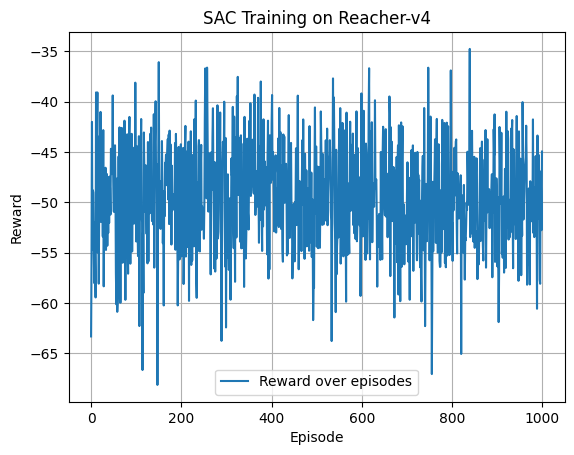

In [10]:
# Define el nombre del entorno y el número de episodios
env_name = "Reacher-v4"
epos = 1000

# Crea el entorno
env = gym.make(env_name)

# Inicializa el agente SAC con los parámetros apropiados
agent = SACAgent(env, lr=0.0001, gamma=0.99, soft_update_tau=0.005, memory_size=10000, hidden_size=256)

# Entrena al agente
learning_data = agent.train(n_episode=epos, batch_size=256, report_freq=10, checkpoint_freq=100,
                            initial_memory=1024, target_actualizations=100)

# Grafica los resultados
plt.plot(learning_data, label='Reward over episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('SAC Training on Reacher-v4')
plt.grid()
plt.legend()
plt.show()

# Cierra el entorno
env.close()

# Detalles de la implementación

## Análisis teórico de sensibilidad de los parámetros de la tabla:

- **Experience Replay (10000)**: El tamaño del buffer de experiencia es un hiperparámetro importante en el entrenamiento de un agente de RL. Un buffer de experiencia más grande puede ayudar a estabilizar el entrenamiento y mejorar la eficiencia del aprendizaje. Sin embargo, un buffer de experiencia más grande también puede requerir más memoria y tiempo de computación. Un buffer de experiencia más pequeño puede ser más eficiente en términos de memoria y tiempo de computación, pero puede ser menos estable y eficiente en términos de aprendizaje. En general, un buffer de experiencia de 10000 parece ser un valor razonable para este problema, pero puede ser necesario ajustar este valor en función de la complejidad del entorno y de los recursos computacionales disponibles.
- **Comienzo del aprendizaje (1024)**: Este parámetro representa la cantidad de acciones aleatorias que se almacenan en el buffer antes de que comienze el aprendizaje. Un valor de 1024 parece ser razonable para este problema. Con un valor más alto, el agente puede explorar más el entorno antes de comenzar el aprendizaje, lo que puede ser beneficioso para la exploración y la estabilidad del entrenamiento. Sin embargo, un valor más alto también puede requerir más tiempo de computación y memoria. Por otro lado, un valor más bajo puede acelerar el inicio del aprendizaje, pero puede ser menos eficiente en términos de exploración y estabilidad del entrenamiento. En general, un valor de 1024 parece ser un buen punto de partida.
- **Número de episodios (>= 1000)**: El número de episodios es un hiperparámetro importante en el entrenamiento de un agente de RL. Un número más alto de episodios puede permitir al agente explorar más el entorno y aprender una política más precisa. Sin embargo, un número más alto de episodios también puede requerir más tiempo de computación y memoria. Este es el parámetro que más directamente afecta la cantidad de tiempo que el agente tiene para aprender, ya que cada episodio representa una oportunidad para el agente de interactuar con el entorno y aprender de sus experiencias.
- **Batch Size (256)**: El tamaño del batch es un hiperparámetro importante en el entrenamiento de un agente de RL. Un tamaño de batch más grande puede ayudar a estabilizar el entrenamiento y mejorar la eficiencia del aprendizaje. Sin embargo, un tamaño de batch más grande también puede requerir más memoria y tiempo de computación. Un tamaño más pequeño puede ser más eficiente en términos de memoria y tiempo de computación, pero puede ser menos estable y eficiente en términos de aprendizaje.
- **$\gamma$ (0.99)**: El factor de descuento gamma es un hiperparámetro importante en el entrenamiento de un agente de RL. Un valor de gamma más alto puede hacer que el agente tenga en cuenta más recompensas futuras en su toma de decisiones, lo que puede ser beneficioso para la planificación a largo plazo. Sin embargo, un valor de gamma más alto también puede hacer que el agente sea más propenso a la sobreestimación de las recompensas futuras y puede hacer que el entrenamiento sea más inestable. Un valor de gamma más bajo puede hacer que el agente se centre más en las recompensas inmediatas y sea más conservador en su toma de decisiones, lo que puede ser beneficioso para la estabilidad del entrenamiento.
- **Número de actualizaciones red target (100)**: El número de actualizaciones de la red objetivo es un hiperparámetro importante en el entrenamiento de un agente de RL. Un número más alto de actualizaciones de la red objetivo puede ayudar a estabilizar el entrenamiento y mejorar la eficiencia del aprendizaje. Sin embargo, un número más alto de actualizaciones de la red objetivo también puede requerir más tiempo de computación y memoria. Un número más bajo de actualizaciones de la red objetivo puede ser más eficiente en términos de memoria y tiempo de computación, pero puede ser menos estable y eficiente en términos de aprendizaje.
- **Learning Rate (0.0001)**: La tasa de aprendizaje es un hiperparámetro importante en el entrenamiento de un agente de RL. Una tasa de aprendizaje más alta puede acelerar el aprendizaje, pero también puede hacer que el entrenamiento sea más inestable. Una tasa de aprendizaje más baja puede hacer que el entrenamiento sea más estable, pero también puede hacer que el aprendizaje sea más lento, ya que el agente necesita más iteraciones para converger.
- **Optimizador (Adam)**: El optimizador es un hiperparámetro importante en el entrenamiento de un agente de RL. El optimizador Adam es un optimizador popular en el aprendizaje profundo y puede ser una buena opción para este problema. El optimizador Adam es un optimizador adaptativo que ajusta la tasa de aprendizaje de forma automática en función de las características de los datos y puede ser eficiente en términos de memoria y tiempo de computación.

## Importancia del factor $\gamma$:

El factor de descuento gamma es un hiperparámetro importante en el entrenamiento de un agente de RL. El factor de descuento gamma determina cuánto peso se le da a las recompensas futuras en la función de valor del agente. Luego es necesario agregarlo ya que las recompensas futuras son inciertas y el agente necesita tener en cuenta la incertidumbre al tomar decisiones. Un valor de gamma más alto puede hacer que el agente tenga en cuenta más recompensas futuras en su toma de decisiones, lo que puede ser beneficioso para la planificación a largo plazo.

## Parámmetros cuya variación no son reelevantes para el tiempo de entrenamiento:

- **Comienzo del aprendizaje**: Este parámetro no afecta significativamente el tiempo de entrenamiento ya que es un hiperparámetro que se utiliza para almacenar acciones aleatorias en el buffer antes de que comience el aprendizaje.
- **$\gamma$**: El factor de descuento gamma no afecta significativamente el tiempo de entrenamiento ya que es un hiperparámetro que se utiliza para determinar cuánto peso se le da a las recompensas futuras en la función de valor del agente y por lo tanto simplemente pondera la recompensa.
- **Learning Rate**: La tasa de aprendizaje no afecta significativamente el tiempo de entrenamiento ya que es un hiperparámetro que se utiliza para ajustar la velocidad de aprendizaje del agente pero que su valor no tiene un impacto significativo en el tiempo de entrenamiento.

# Parametrización de política $\pi$:

La parametrización de la política $\pi$ en aprendizaje por refuerzo permite generalizar a estados no vistos, mejorar la eficiencia computacional y optimizar directamente mediante gradientes. Esto se logra utilizando funciones como redes neuronales para representar la política. La estocasticidad se aborda mediante políticas estocásticas que asignan probabilidades a las acciones y mediante la regularización por entropía, que fomenta la exploración y evita que la política se vuelva determinística prematuramente. Esto se refleja en la función objetivo que maximiza la recompensa esperada junto con un término de entropía para balancear exploración y explotación.

# Actividad 6:

### Target Networks en el Cálculo de los Labels de la Ecuación de Bellman

Las target networks se utilizan en el cálculo de los labels de la ecuación de Bellman para estabilizar el proceso de entrenamiento. En algoritmos como Deep Q-Learning (DQN), si la red principal se actualizara contra sus propias predicciones, esto podría generar inestabilidades debido a actualizaciones altamente correlacionadas. Para mitigar esto, se utiliza una red de destino $\hat{Q}$, que es una copia de la red principal y se actualiza solo periódicamente. Esta red de destino se usa para calcular los valores objetivo, lo que ayuda a reducir las oscilaciones y mejora la estabilidad del entrenamiento.

### Buffer de Memoria (Experience Replay)

El buffer de memoria, o experience replay, almacena experiencias pasadas y permite muestrear aleatoriamente de este conjunto durante el entrenamiento. Esto desacorraciona las experiencias, lo que es esencial para evitar actualizaciones altamente correlacionadas que pueden inestabilizar el aprendizaje. Además, el buffer permite la reutilización de experiencias, mejorando la eficiencia de datos, y mantiene un balance entre experiencias recientes y pasadas, lo que ayuda a evitar el sobreajuste a las circunstancias más recientes del entorno.

### Consecuencias de No Usar el Buffer de Memoria

Sin un buffer de memoria, el entrenamiento dependería solo de experiencias recientes, lo que puede llevar a inestabilidades debido a correlaciones temporales y a un uso ineficiente de los datos. Además, la red podría sobreajustarse a las experiencias más recientes, perdiendo la capacidad de generalizar. Aunque es posible implementar algoritmos sin un buffer de memoria, como en algunos casos de SARSA, en entornos complejos y de alta dimensionalidad, la ausencia del buffer generalmente resulta en un rendimiento inferior en términos de estabilidad y eficiencia del aprendizaje.